In [1]:
# Load packages
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle

Make synthetic data

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=40, n_informative=3,
    n_redundant=2, n_repeated=0, n_classes=2,
    n_clusters_per_class=3, weights=None, flip_y=0.05,
    class_sep=0.1, hypercube=True, shift=0.0,
    scale=1.0, shuffle=True, random_state=2)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
train_test_split(X, y, test_size=0.2, random_state=24)

In [4]:
y.mean()

0.4986

# Early stopping

In [5]:
xgb_model_1 = xgb.XGBClassifier(
    n_estimators=1000,
    verbosity=1,
    use_label_encoder=False,
    objective='binary:logistic',
    learning_rate=0.3)

In [6]:
%%time
xgb_model_1.fit(X_train, y_train, eval_metric="auc", verbose=True)

CPU times: user 42.3 s, sys: 156 ms, total: 42.5 s
Wall time: 11 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [7]:
val_set_pred_proba = xgb_model_1.predict_proba(X_val)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, val_set_pred_proba)
#0.7773798710782294

0.7773798710782294

Now with early stopping.

In [8]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [9]:
%%time
xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                eval_metric='auc',
                verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.80412	validation_1-auc:0.75223
[1]	validation_0-auc:0.84422	validation_1-auc:0.79207
[2]	validation_0-auc:0.85920	validation_1-auc:0.79278
[3]	validation_0-auc:0.86616	validation_1-auc:0.79517
[4]	validation_0-auc:0.88261	validation_1-auc:0.79659
[5]	validation_0-auc:0.88605	validation_1-auc:0.80061
[6]	validation_0-auc:0.89226	validation_1-auc:0.80224
[7]	validation_0-auc:0.89826	validation_1-auc:0.80305
[8]	validation_0-auc:0.90559	validation_1-auc:0.80095
[9]	validation_0-auc:0.91954	validation_1-auc:0.79685
[10]	validation_0-auc:0.92113	validation_1-auc:0.79608
[11]	validation_0-auc:0.92393	validation_1-auc:0.79763
[12]	validation_0-auc:0.92526	validation_1-auc:0.79842
[13]	validation_0-auc:0.92699	validation_1-auc:0.79883
[14]	validation_0-auc:0.93105	validation_1-auc:0.79716
[15]	validation_0-auc:0.94393	validation_1-auc:0.79750
[16]	validation_0-auc:0.95007	validation_1-auc:0.79431
[17]	validation_0-auc:0.95204	validation_1-auc:0.79407
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [10]:
xgb_model_1.get_booster().attributes()

{'best_iteration': '7', 'best_score': '0.80305'}

In [11]:
val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
roc_auc_score(y_val, val_set_pred_proba_2)
#0.8030501882609966

0.8030501882609966

In [12]:
int(xgb_model_1.get_booster().attributes()['best_iteration'])#()#feature_names

7

This is a simple and intuitive way to reduce overfitting.

# Tuning the learning rate

In [13]:
learning_rates = np.linspace(start=0.01, stop=1, num=25)
learning_rates

array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ])

In [14]:
%%time
val_aucs = []
best_iters = []
for learning_rate in learning_rates:
    #Set learning rate and fit model
    xgb_model_1.set_params(**{'learning_rate':learning_rate})
    xgb_model_1.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric='auc',
                    verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba_2))
    
    #Get number of rounds
    best_iters.append(
        int(xgb_model_1.get_booster().attributes()['best_iteration']))

CPU times: user 1min 25s, sys: 667 ms, total: 1min 25s
Wall time: 23.2 s


In [15]:
learning_rate_df = \
pd.DataFrame({'Learning rate':learning_rates,
              'Validation AUC':val_aucs,
              'Best iteration':best_iters})

<AxesSubplot:xlabel='Learning rate'>

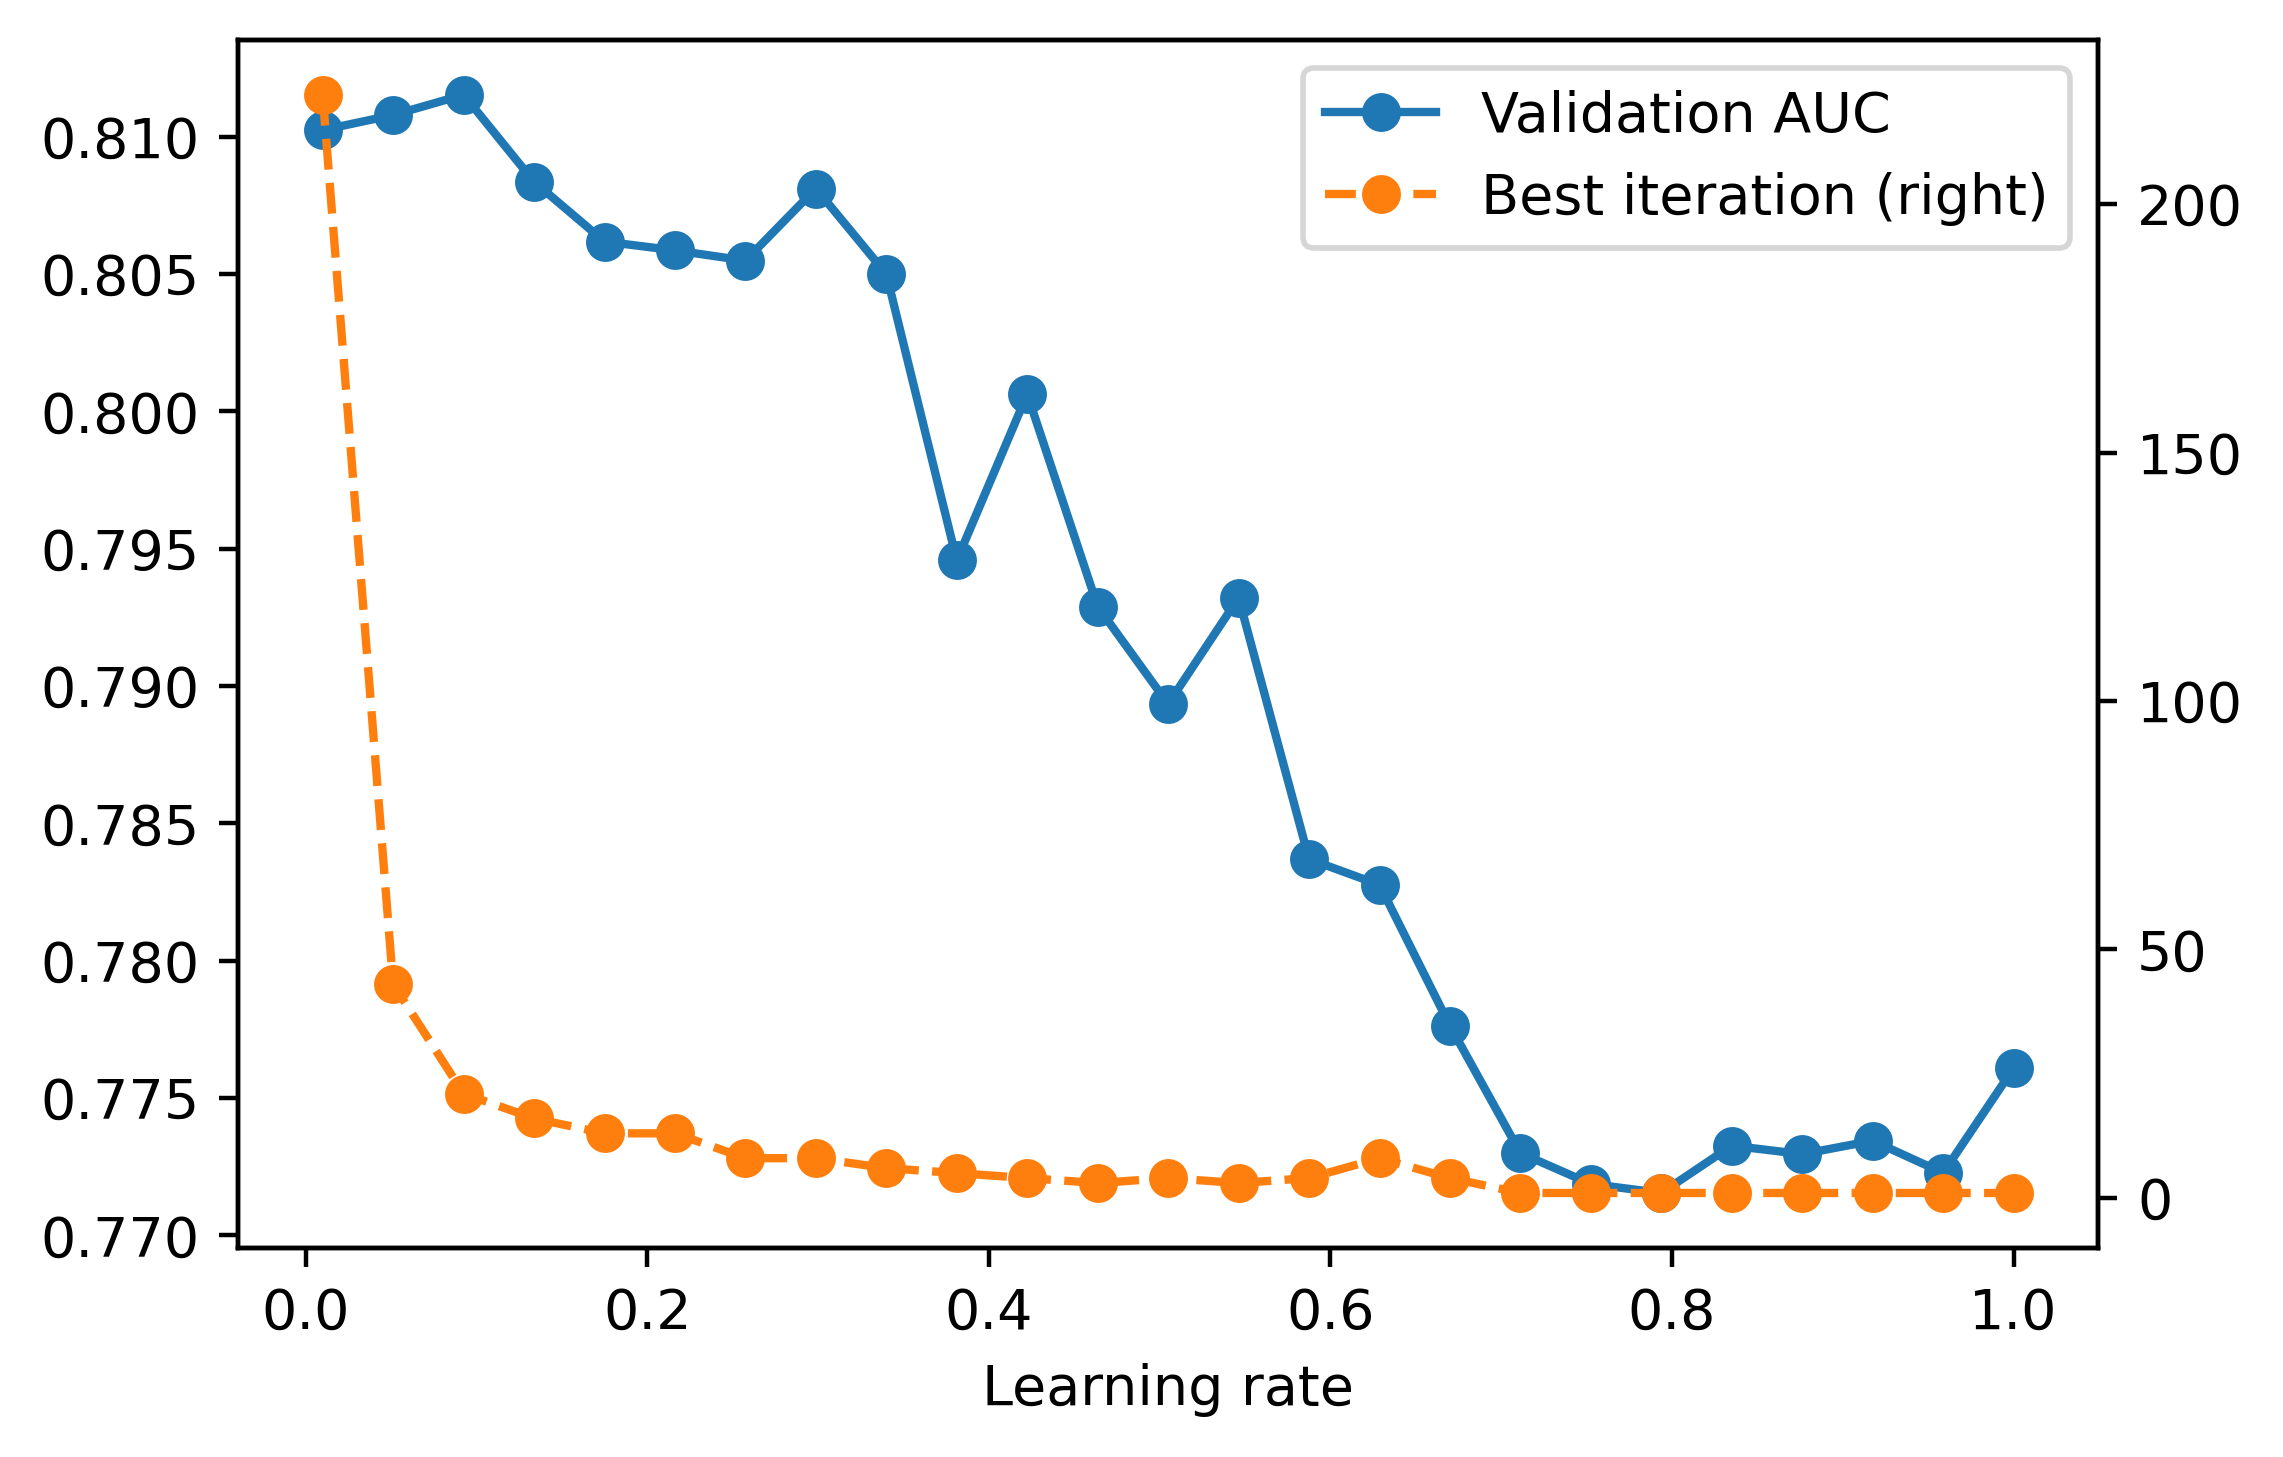

In [16]:
mpl.rcParams['figure.dpi'] = 400
learning_rate_df.set_index('Learning rate')\
.plot(secondary_y='Best iteration', style=['-o', '--o'])

In [17]:
max(val_aucs)
# 0.8115309360232714

0.8115309360232714

# Exercise 22: Tuning XGBoost hyperparameters

In [18]:
from scipy.stats import uniform
param_grid = {'max_depth':[2,3,4,5,6,7],
              'gamma':uniform(loc=0.0, scale=3),
              'min_child_weight':list(range(1,151)),
              'colsample_bytree':uniform(loc=0.1, scale=0.9),
              'subsample':uniform(loc=0.5, scale=0.5),
              'learning_rate':uniform(loc=0.01, scale=0.5)}

In [19]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(0)
n_iter=1000
param_list = list(ParameterSampler(param_grid, n_iter=n_iter,
                                   random_state=rng))
#n_iter=300

Looks like this is consistent if the seed is set:

In [20]:
param_list[0]

{'colsample_bytree': 0.5939321535345923,
 'gamma': 2.1455680991172583,
 'learning_rate': 0.31138168803582195,
 'max_depth': 5,
 'min_child_weight': 104,
 'subsample': 0.7118273996694524}

In [21]:
xgb_model_2 = xgb.XGBClassifier(
    n_estimators=1000,
    verbosity=1,
    use_label_encoder=False,
    objective='binary:logistic')

In [22]:
xgb_model_2.set_params(**param_list[0])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5939321535345923,
              gamma=2.1455680991172583, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.31138168803582195,
              max_delta_step=None, max_depth=5, min_child_weight=104,
              missing=nan, monotone_constraints=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.7118273996694524, tree_method=None,
              use_label_encoder=False, validate_parameters=None, verbosity=1)

In [23]:
%%time
val_aucs = []
# train_aucs = []
counter = 1
for params in param_list:
    #Set hyperparameters and fit model
    xgb_model_2.set_params(**params)
    xgb_model_2.fit(X_train, y_train, eval_set=eval_set,
                    eval_metric='auc',
                    verbose=False, early_stopping_rounds=30)
    
    #Get predicted probabilities and save validation ROC AUC
    val_set_pred_proba = xgb_model_2.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))
    
#     train_set_pred_proba = xgb_model_1.predict_proba(X_train)[:,1]
#     train_aucs.append(roc_auc_score(y_train, train_set_pred_proba))
    
    #Print progress
    if counter % 50 == 0:
        print('Done with {counter} of {n_iter}'.format(
            counter=counter, n_iter=n_iter))
    counter += 1

Done with 50 of 1000
Done with 100 of 1000
Done with 150 of 1000
Done with 200 of 1000
Done with 250 of 1000
Done with 300 of 1000
Done with 350 of 1000
Done with 400 of 1000
Done with 450 of 1000
Done with 500 of 1000
Done with 550 of 1000
Done with 600 of 1000
Done with 650 of 1000
Done with 700 of 1000
Done with 750 of 1000
Done with 800 of 1000
Done with 850 of 1000
Done with 900 of 1000
Done with 950 of 1000
Done with 1000 of 1000
CPU times: user 23min 30s, sys: 27.6 s, total: 23min 58s
Wall time: 7min 50s


In [24]:
xgb_param_search_df = pd.DataFrame(param_list)

In [25]:
xgb_param_search_df.head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample
0,0.593932,2.145568,0.311382,5,104,0.711827
1,0.681305,1.312762,0.455887,2,141,0.691721
2,0.812553,1.586685,0.294022,7,26,0.535518
3,0.178416,0.060655,0.426310,2,83,0.736804
4,0.820820,1.561432,0.349440,2,10,0.768687


In [26]:
# xgb_param_search_df['Training ROC AUC'] = train_aucs
xgb_param_search_df['Validation ROC AUC'] = val_aucs

In [27]:
max_auc = xgb_param_search_df['Validation ROC AUC'].max()
max_auc
# 0.8151220995602575

0.8151220995602575

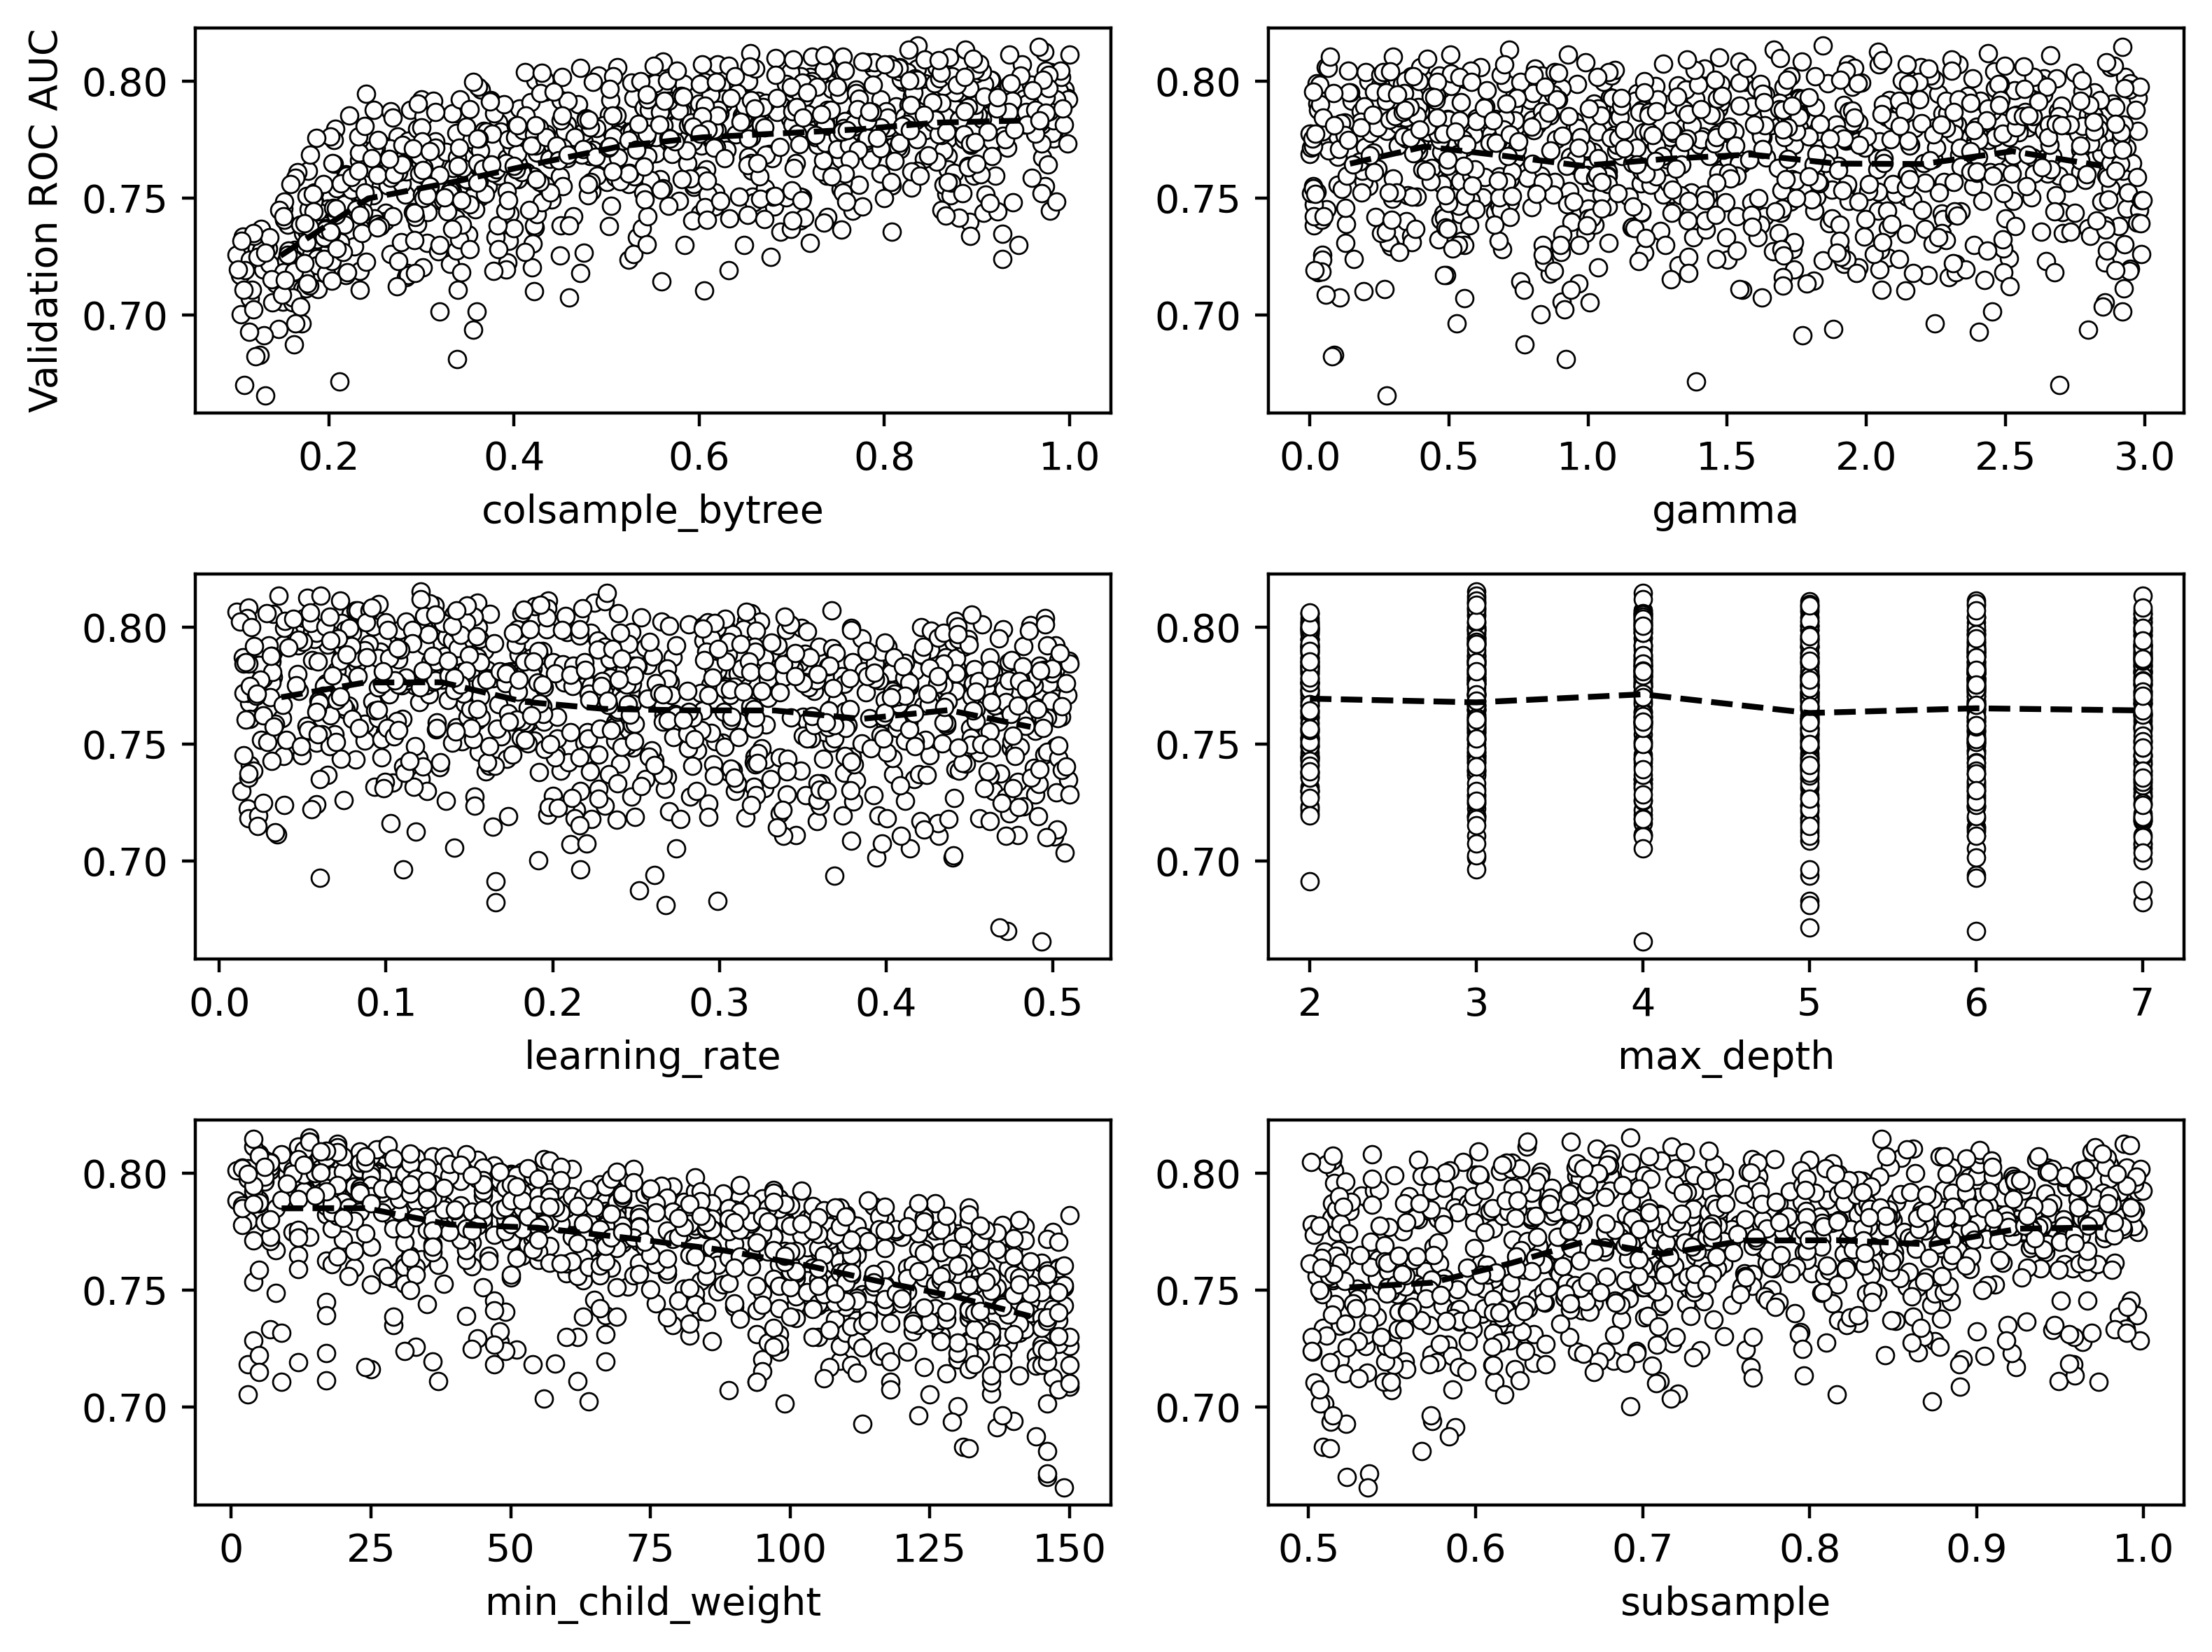

In [28]:
mpl.rcParams['figure.dpi'] = 400
fig, axs = plt.subplots(3,2,figsize=(8,6))
counter = 0
for col in xgb_param_search_df.columns[:-1]:
#     print(col)
    this_ax = axs.flatten()[counter]
    xgb_param_search_df.plot.scatter(
        x=col, y='Validation ROC AUC',
        ax=this_ax, marker='o',
        color='w',
        edgecolor='k',
        linewidth=0.5)
    
    if counter > 0:
        this_ax.set_ylabel('')
    counter += 1
    
    if col != 'max_depth':
        out, bins = pd.qcut(xgb_param_search_df[col], q=10,
                            retbins=True, duplicates='drop')
        half_points = [(bins[ix] + bins[ix+1])/2
                       for ix in range(len(bins)-1)]
    else:
        out = xgb_param_search_df[col]
        half_points = np.sort(xgb_param_search_df[col].unique())
        
    tmp_df = xgb_param_search_df.copy()
    tmp_df['param_decile'] = out
    mean_df = tmp_df.groupby('param_decile').agg(
        {'Validation ROC AUC':'mean'})
    
    this_ax.plot(half_points, mean_df.values, color='k', linestyle='--')
plt.tight_layout()

This is a good illustration of the effects of these hyperparameters, even if there is minimal improvement from tuning them, at least on these synthetic data.

What is the best hyperparameter combination?

In [29]:
max_ix = xgb_param_search_df['Validation ROC AUC'] == max_auc
xgb_param_search_df[max_ix]

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,Validation ROC AUC
308,0.83627,1.843039,0.120745,3,14,0.692646,0.815122


In [30]:
param_list[np.where(max_ix)[0][0]]
# {'colsample_bytree': 0.8362695026564751,
#  'gamma': 1.8430388999388927,
#  'learning_rate': 0.12074508940147886,
#  'max_depth': 3,
#  'min_child_weight': 14,
#  'subsample': 0.6926457795226095}

{'colsample_bytree': 0.8362695026564751,
 'gamma': 1.8430388999388927,
 'learning_rate': 0.12074508940147886,
 'max_depth': 3,
 'min_child_weight': 14,
 'subsample': 0.6926457795226095}